# Stroke Prediction
 - Data aquired from: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset
 - Code to be used for a blog post on handling imbalanced data.
 - Presented here: https://sinnott-cj.medium.com/stroke-prediction-imbalanced-data-b6c406a81b8a

#### Importing Libraries

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,\
                            precision_score, recall_score, roc_auc_score,\
                            plot_confusion_matrix, classification_report, plot_roc_curve, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#from category_encoders import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from imblearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest

# Data Import & Cleaning

In [29]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

Binarizing / Vectorizing:

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [31]:
text_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
[print(df[i].unique()) for i in df[text_cols]]

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


[None, None, None, None, None]

In [32]:
df['gender'] = np.where(df['gender'] == 'Male', 1, 0)

In [33]:
df['ever_married'] = np.where(df['ever_married'] == 'Yes', 1, 0)

In [34]:
df['Residence_type'] = np.where(df['Residence_type'] == 'Urban', 1, 0)

In [35]:
df['smoking_status'] = np.where(((df['smoking_status'] == 'smokes') | (df['smoking_status'] == 'formerly smoked')), 1, 0)

In [36]:
for i in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    print(df[i].unique())

[1 0]
[1 0]
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
[1 0]
[1 0]


In [37]:
#not imputing bmi due to the clinical importance as seen in the heatmap
df.dropna(subset = ['bmi'], inplace = True)

Removing outliers:

In [38]:
iso = IsolationForest(n_estimators = 1000, contamination = 0.03)

In [39]:
outs = pd.Series(iso.fit_predict(df[['bmi', 'avg_glucose_level']]), name = 'outliers')

In [40]:
outs.value_counts()

 1    4761
-1     148
Name: outliers, dtype: int64

In [41]:
df = pd.concat([outs.reset_index(), df.reset_index()], axis = 1, ignore_index = False).drop(columns = 'index')

In [42]:
df = df[df['outliers'] == 1]

In [43]:
# lost positive for stroke values
df['stroke'].value_counts()

0    4565
1     196
Name: stroke, dtype: int64

Pre-processing:

In [44]:
le = LabelEncoder()
ss = StandardScaler()

In [45]:
df['work_type'] = le.fit_transform(df['work_type'])

In [46]:
text_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
[print(df[i].unique()) for i in df[text_cols]]

[1 0]
[1 0]
[2 3 0 4 1]
[1 0]
[1 0]


[None, None, None, None, None]

In [47]:
num_cols = ['age', 'avg_glucose_level', 'bmi']
df[num_cols] = ss.fit_transform(df[num_cols])

In [48]:
X = df.drop(columns = ['stroke', 'id', 'outliers'])
y = df.stroke

# Final Model
- StandardScaler for numeric data.
- LabelEncoding for strings
- RandomOverSampler for imbalanced target

SMOTENC

In [49]:
from imblearn.over_sampling import RandomOverSampler

In [50]:
ros = RandomOverSampler()

In [51]:
X, y = ros.fit_resample(X, y)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [53]:
model = RandomForestClassifier()

In [54]:
model.fit(X_train, y_train)

RandomForestClassifier()

In [55]:
y_pred = model.predict(X_test)

In [56]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

classification_eval(y_test, y_pred)

accuracy  = 0.995
precision = 0.99
recall    = 1.0
f1-score  = 0.995
roc auc   = 0.995
null accuracy = 0.5


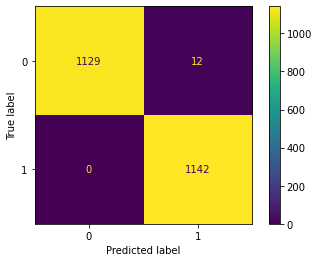

In [57]:
plot_confusion_matrix(model, X_test, y_test);

In [58]:
y_pred_prob = model.predict_proba(X_test)

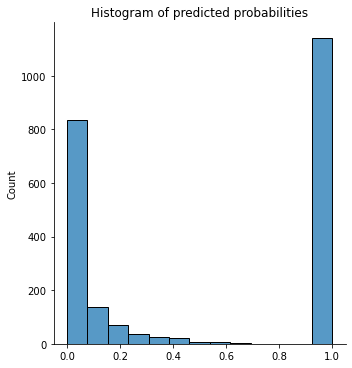

In [59]:
sns.displot(y_pred_prob[:, 1]);
plt.title('Histogram of predicted probabilities');

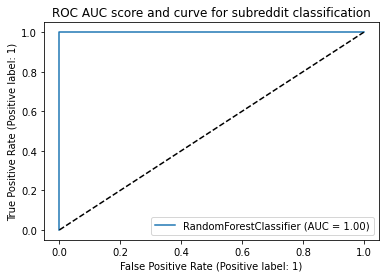

In [60]:
plot_roc_curve(model, X_test, y_test)
plt.title('ROC AUC score and curve for subreddit classification');
plt.plot([0,1], [0,1], 'k--')
plt.show();

In [61]:
feat_names = [i for i in X_train]

In [62]:
classed = [i for i in y_train]

In [63]:
feat_import_df = pd.DataFrame({'importances': model.feature_importances_, 
 'name': feat_names}).sort_values('importances')

In [64]:
feat_import_df.sort_values('importances', ascending = False).head(15)

,importances,name
1,0.380529,age
7,0.220614,avg_glucose_level
8,0.185823,bmi
5,0.057551,work_type
4,0.034869,ever_married
2,0.033388,hypertension
9,0.024312,smoking_status
6,0.024242,Residence_type
0,0.022737,gender
3,0.015935,heart_disease


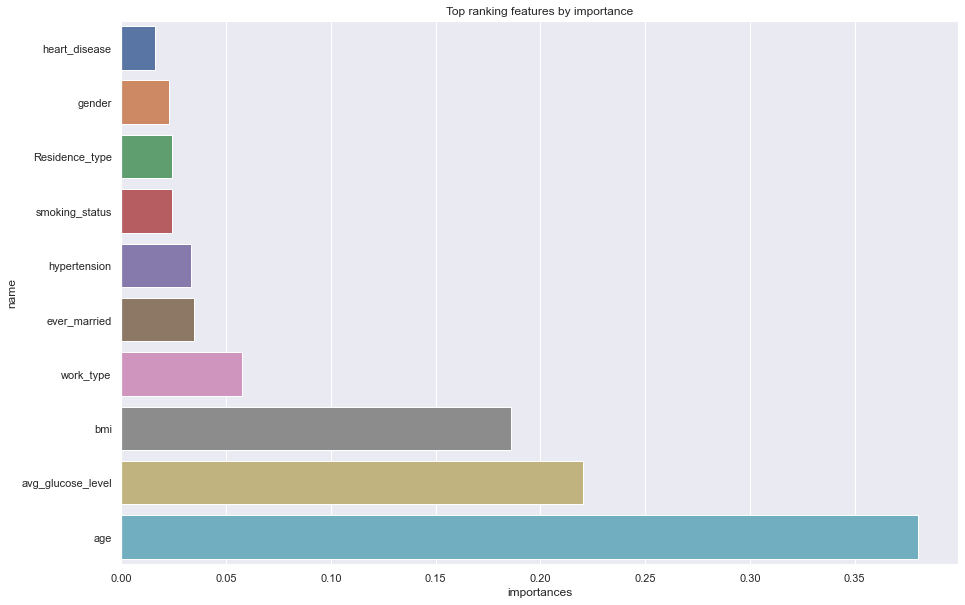

In [65]:
sns.set(style="darkgrid", context="notebook")
plt.figure(figsize=(15, 10))
x = feat_import_df['importances'].tail(21)
y = feat_import_df['name'].tail(21)
sns.barplot(x = x, y = y).set_title('Top ranking features by importance');